# Intro to Python
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

The first step in using Python is to load in the relevant packages. Assigning abbreviations when importing packages, makes it easier to call the tools later. The abbreviations below are very common.

In [1]:
# load some key packages:
import numpy as np                # a numerical package
import pandas as pd               # a data analysis package
import matplotlib.pyplot as plt   # a scientific plotting package

# to display the plots in the same document
%matplotlib inline

If the cell throws an error, you haven't probably intalled the required packages correctly. To install them open a terminal/command window and run: `conda install package_name`. 

As a demo of the language, we will plot sin and cos of a range of points on the same axis. The first step is to define the points: 

In [2]:
# define an array of points (start, end, by)
x = np.arange(0,6*np.pi,0.1)

# check the array
print(x)

[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9  15.   15.1  15.2  15.3  15.4  15.5
  15.6  15.7  15.8  15.9  16.   16.1  16.2  16.3  1

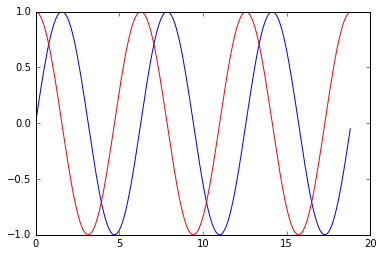

In [3]:
# plot the sin of these points
plt.plot(x, np.sin(x), 'blue')

# plot the cos of these points
plt.plot(x, np.cos(x),'red')

# show that plot below
plt.show()

From this example you can see how tools from different packages are called using the abbreviations assigned at the beginning of the notebook. 

## NetCDF
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

There are several different tools for working with netcdf data using python. This notebook focuses on xarray, because of its impressive time capabilities. To open the netcdf file, you need the Data URL which you can find at [THREDDS](http://hydromet-thredds.princeton.edu:9000/thredds). The URL goes in quotes because otherwise Python will think you are trying to call a variable that you already assigned a value to (like x in the example above).

In [4]:
# load the netcdf-handling package:
import xarray as xr

# from THREDDS server. 
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/butler.nc'

# open the file and assign it the name: ds
ds = xr.open_dataset(data_url)

# check it out
print(ds)

<xarray.Dataset>
Dimensions:                  (time: 44587)
Coordinates:
    lat                      float64 ...
    lon                      float64 ...
    station_name             |S64 ...
  * time                     (time) datetime64[ns] 2011-03-01T18:00:00 ...
Data variables:
    AirTC_2_Avg              (time) float64 ...
    AirTC_Avg                (time) float64 ...
    Albedo_1_Avg             (time) float64 ...
    Albedo_Avg               (time) float64 ...
    CmCIR_Avg                (time) float64 ...
    CmGIR_Avg                (time) float64 ...
    DnTot_Avg                (time) float64 ...
    IR01DnCo_Avg             (time) float64 ...
    IR01Dn_Avg               (time) float64 ...
    IR01UpCo_Avg             (time) float64 ...
    IR01Up_Avg               (time) float64 ...
    LPO2Dn_Avg               (time) float64 ...
    Max_Run_Tot_mm_24hr_Max  (time) float64 ...
    Max_Run_Tot_mm_2hr_Max   (time) float64 ...
    NR01TC_Avg               (time) float64 

At this point you haven't pulled over any actual data, you just have a way of referencing the dataset. To get the data we select the variable that we are interested in -in this example we will use air temperature (AirTC_Avg). 

In [5]:
variable = 'AirTC_Avg'

# check it out
print(ds[variable])

<xarray.DataArray 'AirTC_Avg' (time: 44587)>
array([ 6.504,  7.484,  8.48 , ...,  4.682,  5.083,  5.333])
Coordinates:
    lat           float64 ...
    lon           float64 ...
    station_name  |S64 ...
  * time          (time) datetime64[ns] 2011-03-01T18:00:00 ...
Attributes:
    units: Deg C
    method: Avg


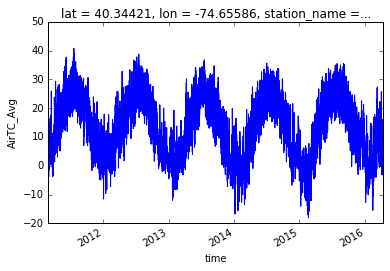

In [6]:
# plot all the data
ds[variable].plot()

## Summary stats
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

Once you have loaded the dataset and chosen a variable to look at, you can access lots more tools by converting it into a pandas.DataFrame object. With a dataframe you can create boxplots and compute the summary statistics on that variable over the entire span of the data.

In [7]:
# convert to a pandas object and then to a dataframe
df = ds[variable].to_pandas().to_frame(name=variable)

# get a summary of the data including the percentiles listed
df.describe(percentiles=[.1,.25,.5,.75,.9])

,AirTC_Avg
count,44587.000000
mean,12.861019
std,10.288328
min,-17.900000
10%,-0.630800
25%,4.737500
50%,13.290000
75%,21.000000
90%,26.204000
max,40.770000


We can explore the annual temperature cycle by creating box plots for each month. We can control the whiskers and set them to .1 and .9 percentile (expressed as percentages so 10, 90). We can also eliminate outliers by setting sym='' (no symbol so they won't plot).

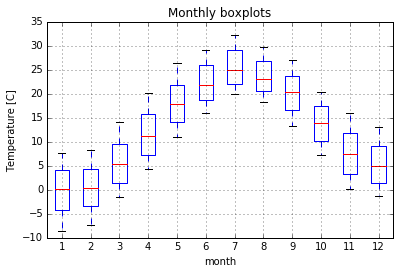

In [8]:
# create a box plot
df.boxplot(column=variable, by=df.index.month, whis= [10, 90], sym='')

# set the labels
plt.xlabel('month')
plt.ylabel('Temperature [C]')
plt.title('Monthly boxplots')
plt.suptitle('')

plt.show()

## Time slices
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

We often are more interested in looking at one particular time, rather than the whole record. Here is one way to select a particular time range:

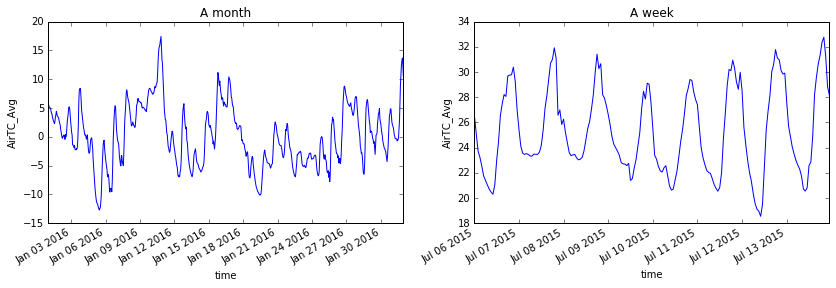

In [9]:
# choose a date period (such as a month)
a_month = ds[variable].sel(time='2016-01')

# or grab the range between two specific days
a_week =  ds[variable].sel(time=slice('2015-07-06', '2015-07-13'))

# Create a figure with two subplots 
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,4))

# plot the month of data in the first subplot
a_month.plot(ax=axes[0])
axes[0].set_title('A month')

# plot the week of data in the first subplot
a_week.plot(ax=axes[1])
axes[1].set_title('A week')

plt.show()

## Multiple variables
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

To plot several variables over a defined period of time, we can use a list of variables, and a slice of time to generate a pandas.DataFrame. Converting to a pandas.DataFrame gives us lots of options for analysis, but it also means that we are going to load the data into local memory, so be careful how much data you try to load. This can get slow if you try to load all the variables for years of data being collected every minute. 

In [10]:
# slice the dataset by time and grab variables of interest
vars_for_a_week = ds[['Rain_mm_3_Tot', 'VW']].sel(time=slice('2015-07-06', '2015-07-13'))
print(vars_for_a_week)

<xarray.Dataset>
Dimensions:        (time: 192)
Coordinates:
  * time           (time) datetime64[ns] 2015-07-06 2015-07-06T01:00:00 ...
    station_name   |S64 ...
    lat            float64 ...
    lon            float64 ...
Data variables:
    Rain_mm_3_Tot  (time) float64 ...
    VW             (time) float64 ...
Attributes:
    featureType: timeSeries
    history: Created 2016-04-11 09:36:15.597480
    description: Butler Green Roof Station
    Conventions: CF-1.6
    DODS.strlen: 6
    DODS.dimName: string6


In [11]:
# convert to pandas.dataframe
df = vars_for_a_week.to_dataframe()[['Rain_mm_3_Tot', 'VW']]
df.head()

,Rain_mm_3_Tot,VW
time,,
2015-07-06 00:00:00,0.0,0.181
2015-07-06 01:00:00,0.0,0.180
2015-07-06 02:00:00,0.0,0.179
2015-07-06 03:00:00,0.0,0.178
2015-07-06 04:00:00,0.0,0.178


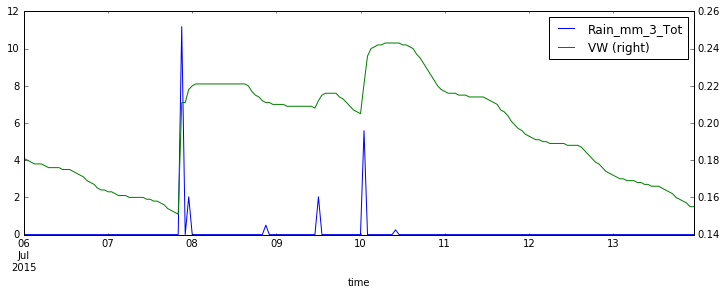

In [12]:
# plot on left and right axes
df.plot(secondary_y='VW', figsize=(12,4))
plt.show()

## Multiple sites
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

There are numerous situations in which you can imagine wanting to combine data from multiple monitoring stations. This can be a bit tricky because the data are recorded at different frequencies. For instance: Butler records hourly data, and Uppper Washington Stream records 1minute data. In this example we combine water levels from upstream, downstream, and the lake, and compare these to rainfall from Broadmead.

In [13]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/broadmead.nc'
ds = xr.open_dataset(data_url)
broadmead_rain_ds = ds[['Rain_1_mm_Tot', 'Rain_2_mm_Tot']].sel(time=slice('2016-02-23', '2016-02-26'))
broadmead_rain = broadmead_rain_ds.to_dataframe().drop(['lat','lon','station_name'], axis=1)
ds.close()

In [14]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/washington_lake.nc'
ds = xr.open_dataset(data_url)
washington_lake_level_ds = ds['Lvl_cm_Avg'].sel(time=slice('2016-02-23', '2016-02-26'))
washington_lake_level = washington_lake_level_ds.to_dataframe().drop(['lat','lon','station_name'], axis=1)
ds.close()

In [15]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/washington_up.nc'
ds = xr.open_dataset(data_url)
washington_up_level_ds = ds['Corrected_cm_Avg'].sel(time=slice('2016-02-23', '2016-02-26'))
washington_up_level = washington_up_level_ds.to_dataframe().drop(['lat','lon','station_name'], axis=1)
ds.close()

In [16]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/washington_down.nc'
ds = xr.open_dataset(data_url)
washington_down_level_ds = ds['Corrected_cm_Avg'].sel(time=slice('2016-02-23', '2016-02-26'))
washington_down_level = washington_down_level_ds.to_dataframe().drop(['lat','lon','station_name'], axis=1)
ds.close()

Compute storm depth by subtracting base depth (taken as the first value in the data for the selected time)

In [17]:
washington_up_storm = washington_up_level-washington_up_level.iloc[0,0]
washington_down_storm = washington_down_level-washington_down_level.iloc[0,0]
washington_lake_storm = washington_lake_level-washington_lake_level.iloc[0,0]

Generate a presentation-quality plot and save it

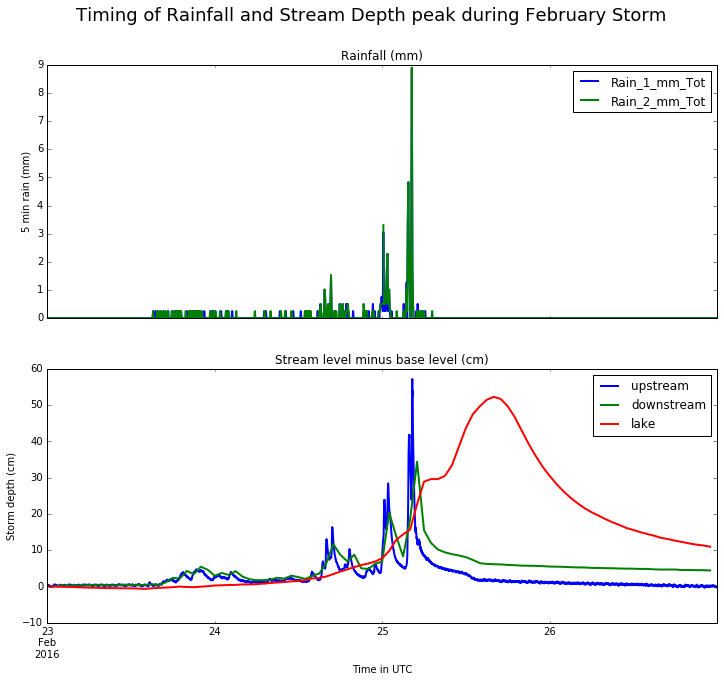

In [18]:
# create a figure with 2 subplots 
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,10), sharex=True)

broadmead_rain.plot(ax=axes[0], linewidth=2)
washington_up_storm.plot(ax=axes[1], linewidth=2)
washington_down_storm.plot(ax=axes[1], linewidth=2)
washington_lake_storm.plot(ax=axes[1], linewidth=2)

# set titles and legends
plt.suptitle('Timing of Rainfall and Stream Depth peak during February Storm', fontsize=18)
axes[0].set_title('Rainfall (mm)')
axes[0].set_ylabel('5 min rain (mm)')

axes[1].set_title('Stream level minus base level (cm)')
axes[1].legend(['upstream','downstream', 'lake'])
axes[1].set_ylabel('Storm depth (cm)')
axes[1].set_xlabel('Time in UTC')

# save fig to current folder
plt.savefig('Rain and discharge.png')
plt.show()

## Using functions
[NetCDF](#NetCDF) | [Summary stats](#Summary-stats) | [Time slices](#Time-slices) | [Multiple variables](#Multiple-variables) |[Multiple sites](#Multiple-sites) | [Using functions](#Using-functions)

You might have noticed that the way we pulled data from multiple datasets was redundant. To simplify this process, we can write a quick function that can be used to pull from any site, any variable and setting your own start and end times. To show how this works, we will use a function to compare tipping bucket rain gage data to disdrometer data.

In [19]:
def select(site, var, start, end):
    """
    Select data from netcdf file hosted on the Princeton Hydrometeorology thredds server

    Parameters
    -----------
    site: one of the monitoring stations in quotes ('broadmead')
    var: one of the variables from this site in quotes ('Rain_1_mm_Tot'), 
         or a list of variables(['Hc', 'Hs'])
    start: starting time for data.frame ('YYYY-MM-DD hh:mm:ss')
    end: ending time for data.frame ('YYYY-MM-DD hh:mm:ss')

    Returns
    -------
    df: pandas.DataFrame object with time index and the variable(s) as the column(s)
    """

    import xarray as xr

    data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/'+ site+'.nc'
    ds = xr.open_dataset(data_url)
    _ds = ds[var].sel(time=slice(start, end))
    df = _ds.to_dataframe().drop(['lat','lon','station_name'], axis=1)
    ds.close()
    return df

Functions can be defined within a notebook as we did above, but it is often more helpful to save them in files that we can use again and again from anywhere. The above function is saved in a file called [select.py](http://nbviewer.jupyter.org/github/jsignell/intro-to-netcdf/blob/master/select.py). To load the function from there first make sure that you have downloaded the file and placed it in the current folder (right click and save to same folder as notebook), then you can use the function by importing the function from the package:

    from select import select

If you forget how the function works, run: `select?` to see the documentation.

In [20]:
broadmead_rain = select('broadmead', ['Rain_1_mm_Tot','Rain_2_mm_Tot'], '2016-02-23', '2016-02-26 12:00')
washington_lake_level = select('washington_lake', 'Lvl_cm_Avg', '2016-02-23', '2016-02-26 12:00')
washington_down_level = select('washington_down', 'Corrected_cm_Avg', '2016-02-23', '2016-02-26 12:00:00')
washington_up_level = select('washington_up', 'Corrected_cm_Avg', '2016-02-23', '2016-02-26 12:00')

Compute the storm depth and plot exactly as we did above:

In [21]:
washington_up_storm = washington_up_level-washington_up_level.iloc[0,0]
washington_down_storm = washington_down_level-washington_down_level.iloc[0,0]
washington_lake_storm = washington_lake_level-washington_lake_level.iloc[0,0]

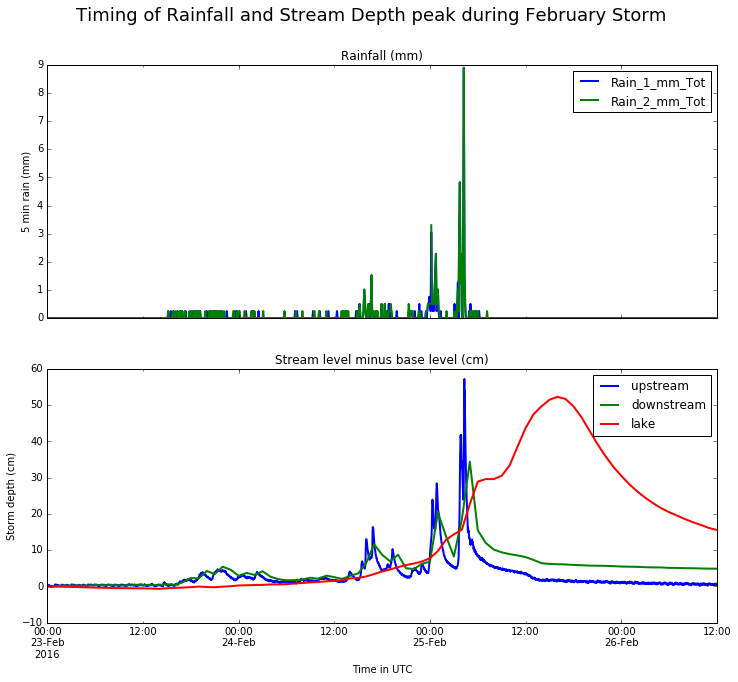

In [22]:
# create a figure with 2 subplots 
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,10), sharex=True)

broadmead_rain.plot(ax=axes[0], linewidth=2)
washington_up_storm.plot(ax=axes[1], linewidth=2)
washington_down_storm.plot(ax=axes[1], linewidth=2)
washington_lake_storm.plot(ax=axes[1], linewidth=2)

# set titles and legends
plt.suptitle('Timing of Rainfall and Stream Depth peak during February Storm', fontsize=18)
axes[0].set_title('Rainfall (mm)')
axes[0].set_ylabel('5 min rain (mm)')

axes[1].set_title('Stream level minus base level (cm)')
axes[1].legend(['upstream','downstream', 'lake'])
axes[1].set_ylabel('Storm depth (cm)')
axes[1].set_xlabel('Time in UTC')

plt.show()

When you are comfortable with the material in this notebook, you can move on to [Advanced Methods in Python](http://nbviewer.jupyter.org/github/jsignell/intro-to-netcdf/blob/master/Advanced%20methods%20in%20Python.ipynb)